In [1]:
# Import raw data from Excel
import pandas as pd
filepath = 'C:/Users/PXY/Desktop/Orange_week.xlsx';
sheetname = 'main'
df = pd.read_excel ( filepath, sheet_name = sheetname );
df.describe()
df.head(10)

,Year,Week,Cases,Rainfalls,No.of Raindays,Max. temperature,Min. temperature,Mean temp,Fatality
0,2010,week1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,week2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,week3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,week4,NaN,286.0,22.0,32.883871,23.751613,26.945161,NaN
4,2010,week5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2010,week6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2010,week7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2010,week8,36.0,241.8,11.0,34.385714,24.535714,28.382143,NaN
8,2010,week9,65.0,NaN,NaN,NaN,NaN,NaN,NaN
9,2010,week10,46.0,NaN,NaN,NaN,NaN,NaN,NaN


                  Rainfalls  Max. temperature  Min. temperature  Mean temp  \
Rainfalls          1.000000         -0.339572         -0.276648  -0.415492   
Max. temperature  -0.339572          1.000000          0.702841   0.928815   
Min. temperature  -0.276648          0.702841          1.000000   0.864220   
Mean temp         -0.415492          0.928815          0.864220   1.000000   
Cases              0.171039         -0.261803         -0.159618  -0.217271   

                     Cases  
Rainfalls         0.171039  
Max. temperature -0.261803  
Min. temperature -0.159618  
Mean temp        -0.217271  
Cases             1.000000  


C:\Users\PXY\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


"std_value = data['Cases'].std()\nmean_value = data['Cases'].mean()\nmax_boundary = mean_value + std_value\nmin_boundary = max( mean_value - std_value, 0 )\nindex = ( data['Cases'] > max_boundary ) | ( data['Cases'] < min_boundary )\n\nimport numpy as np\ndata.loc[index,'Cases'] = np.nan\ndata['Cases'].bfill( inplace = True );\ndata['Cases'].ffill( inplace = True );\n\nplt.figure()\nplt.plot_date(data['Date'], data['Cases'], linestyle = 'solid', marker = 'None' )\n"

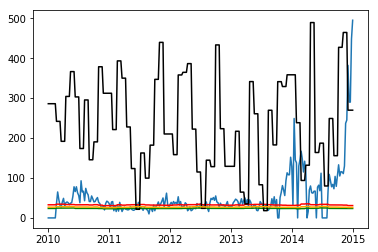

In [3]:
# Data preprocessing
# Set NaN to 0.0 for Cases & Fatality
df['Cases'].fillna( 0, inplace = True )
df['Fatality'].fillna(0, inplace = True )

# Set others to first found values
df['Rainfalls'].ffill( inplace = True );
df['Max. temperature'].ffill( inplace = True );
df['Min. temperature'].ffill( inplace = True );
df['Mean temp'].ffill( inplace = True );

# Ffill doesn't fill in the first three NaN, thus need to do another bfill
df['Rainfalls'].bfill( inplace = True );
df['Max. temperature'].bfill( inplace = True );
df['Min. temperature'].bfill( inplace = True );
df['Mean temp'].bfill( inplace = True );

# Add new column
import datetime 
date = []
for index,row in df.iterrows():
    row['Date'] = datetime.datetime.strptime( str( row['Year'])+ row['Week'] + "-1", "%Yweek%W-%w")
    date.append( row['Date'])

df['Date'] = date

# Verify if all the anomalies are gone and new column added succesfully
df.dtypes

# Create a new data frame
data = pd.DataFrame()
data['Date'] = df['Date']
data['Rainfalls'] = df['Rainfalls'];
data['Max. temperature'] = df['Max. temperature']
data['Min. temperature'] = df['Min. temperature']
data['Mean temp'] = df['Mean temp']
data['Cases'] = df['Cases']

# Since there is no case reported since 2015, drop 2015 data from time series prediction
data.drop(data.tail(52).index,inplace=True) #drop bottom 52 which is data from 2015 

# Show the data in chart
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
dates = matplotlib.dates.date2num(df['Date'])
plt.plot_date(data['Date'], data['Cases'], linestyle = 'solid', marker = 'None')
plt.plot_date(data['Date'], data['Max. temperature'], linestyle = 'solid', marker = 'None', color = 'red')
plt.plot_date(data['Date'], data['Min. temperature'], linestyle = 'solid', marker = 'None', color = 'green')
plt.plot_date(data['Date'], data['Rainfalls'], linestyle = 'solid', marker = 'None', color = 'black')
plt.plot_date(data['Date'], data['Mean temp'], linestyle = 'solid', marker = 'None', color = 'orange' )

print( data.corr() )

# Filter anomalies by using mean+std dev or mean - std dev
'''std_value = data['Cases'].std()
mean_value = data['Cases'].mean()
max_boundary = mean_value + std_value
min_boundary = max( mean_value - std_value, 0 )
index = ( data['Cases'] > max_boundary ) | ( data['Cases'] < min_boundary )

import numpy as np
data.loc[index,'Cases'] = np.nan
data['Cases'].bfill( inplace = True );
data['Cases'].ffill( inplace = True );

plt.figure()
plt.plot_date(data['Date'], data['Cases'], linestyle = 'solid', marker = 'None' )
'''
#from scipy.signal import savgol_filter
#filtered_case = savgol_filter(data['Cases'], 11,2)
#plt.plot_date(dates,filtered_case,color ='red', linestyle = 'solid', marker= 'None')
#plt.show()'''

In [19]:
# Normalizing data
# This step is really useful on improving model performance
import sklearn
from sklearn.preprocessing import MinMaxScaler
cols_to_norm = [ 'Max. temperature','Cases']
sc = MinMaxScaler();
scaled_data = data.copy()
scaled_data[cols_to_norm] = sc.fit_transform(data[cols_to_norm])
 
# Split into train and test sets",
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = scaled_data[:train_size], scaled_data.tail(test_size)

# Get the subset of the data for training
training_set = train.iloc[:, [2,5]].values
# Define the timestep
timestep = 5

# Create input for training
import numpy as np
X_train = []
y_train =[]
for i in range(timestep, len(training_set)):
    X_train.append(training_set[i-timestep:i,[0,1]]);
    y_train.append(training_set[i,1])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))   

In [23]:
# Build and train the model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

regressor = tf.keras.Sequential()

regressor.add(LSTM(units = timestep, return_sequences = True, input_shape = (X_train.shape[1], 2)))
regressor.add(Dropout(0.2) )

regressor.add(LSTM(units = timestep, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = timestep, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = timestep))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
203/203 [==============================] - 6s 31ms/sample - loss: 0.0065
Epoch 2/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0038
Epoch 3/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0022 0s - loss: 0.002
Epoch 4/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0021
Epoch 5/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0021
Epoch 6/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0021
Epoch 7/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0019
Epoch 8/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0018
Epoch 9/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0019
Epoch 10/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0019
Epoch 11/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0021
Epoch 12/100
203/203 [==============================] - 

203/203 [==============================] - 0s 2ms/sample - loss: 0.0011
Epoch 98/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0011
Epoch 99/100
203/203 [==============================] - 0s 2ms/sample - loss: 9.8308e-04
Epoch 100/100
203/203 [==============================] - 0s 2ms/sample - loss: 9.6791e-04


In [24]:
# Create test data for prediction
test_set = training_set[-timestep:]
test_set = np.concatenate(( (test.iloc[:, [2,5]].values),test_set ) )
X_test = []

for i in range(timestep, len(test) + timestep ):
    X_test.append(test_set[i-timestep:i, [0,1]])
   
X_test = np.array(X_test)

# Make prediction
predicted_cases = regressor.predict(X_test)

# Transform prediction result
result = np.zeros(shape=(len(predicted_cases),2))
result[:,1] = predicted_cases[:,0]
predict = sc.inverse_transform(result)[:,1]
print(predict)

[152.60346383 239.18363795 137.3963137  110.22872552  93.43136743
 189.77992818 204.01383474 198.23910579 162.24883229 124.29823413
  99.06558216  48.76200601  22.52180066  39.5693884   64.93372545
  68.74163881  59.56778593  56.95692837  54.22289036  49.06835653
  44.93772145  78.44142795  72.74144813  57.11631797  44.92893286
  14.99996725  15.33963919  17.73552105  25.69849905  45.06369743
  87.88609341 105.02168879  90.39825171  83.94123584  88.59933034
  93.28418523 110.74286744 111.20348856 135.08748427 143.70281339
 129.18365926 141.89493746 159.62890953 199.97609764 267.20488876
 339.92664278 365.84259957 400.03073573 379.07486469 399.73353893
 425.68259954 368.04674774]


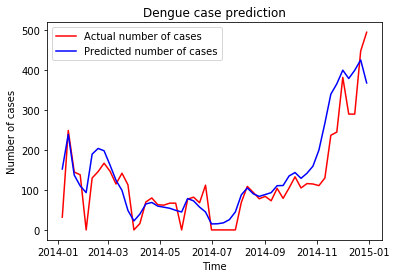

Test RMSE: 52.877


In [25]:
# Get real data
real_cases = data['Cases'].tail(test_size).values

# Visualising the results
plt.plot(data['Date'].tail(test_size),real_cases, color = 'red', label = 'Actual number of cases')
plt.plot(data['Date'].tail(test_size), predict, color = 'blue', label = 'Predicted number of cases')
plt.title('Dengue case prediction')
plt.xlabel('Time')
plt.ylabel('Number of cases')
plt.legend()
plt.show()

# Calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(real_cases, predict))
print('Test RMSE: %.3f' % rmse)

fullresult = pd.DataFrame()
fullresult['Date'] = data['Date'].tail(test_size)
fullresult['Actual'] = real_cases
fullresult['Predicted'] = predict.astype(int)
fullresult.to_csv('C:/Users/PXY/Desktop/multifeatures_result.csv');
